## According to MusicVAE

In [ ]:
import os
import pretty_midi
import json
import numpy as np
import matplotlib.pyplot as plt
import random
import pygame

os.environ['CUDA_VISIBLE_DEVICES'] = '6'


pygame 2.6.1 (SDL 2.28.4, Python 3.8.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# load data
path = "../../dataset/midi_dataset/filtered_midi_imgs_10_000.npy"
# path = "../../dataset/quickdraw_dataset/The The Great Wall_100.npy"
midi_data = np.load(path, allow_pickle=True,)
print(f"Loaded {len(midi_data)} midi files from {path}")
print(f"Shape of midi data: {midi_data.shape}")



Loaded 10000 midi files from ../../dataset/midi_dataset/filtered_midi_imgs_10_000.npy
Shape of midi data: (10000, 100, 100)


Batch shape: torch.Size([256, 100, 100])


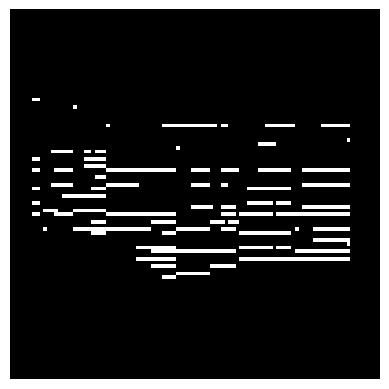

In [3]:
# make dataset 
import torch
from torch.utils.data import Dataset, DataLoader

picked_num = 256
picked_midi = midi_data[:picked_num]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MidiDataset(Dataset):
    def __init__(self, midi_data):
        self.midi_data = midi_data

    def __len__(self):
        return len(self.midi_data)

    def __getitem__(self, idx):
        midi_file = self.midi_data[idx]
        return midi_file
# Create a dataset and dataloader
midi_dataset = MidiDataset(picked_midi)
midi_dataloader = DataLoader(midi_dataset, batch_size=256, shuffle=True)
# Check the shape of the data
for batch in midi_dataloader:
    print(f"Batch shape: {batch.shape}")
    break
# Visualize the data
def visualize_midi(midi_file):
    plt.imshow(midi_file, cmap='gray')
    plt.axis('off')
    plt.show()
# Visualize a random midi file
random_idx = random.randint(0, len(midi_data) - 1)
midi_file = midi_data[random_idx]
visualize_midi(midi_file)


In [24]:
# MusicVAE
import torch.nn as nn

"""
Encoder: 
use a lstm to encode the midi file into a latent space

midi file (bsz, 100, 100) -> (100) * (bsz, 100, 1), time step = 100, dim = 100

LSTM: input -> (bsz, h_dim) (i.e., h_T_left) + (bsz, h_dim) (i.e., h_T_right)

mu = W_mu * h_T + b_mu
sigma = log(exp(W_sigma * h_T + b_sigma)+1)

Decoder: hierarchical RNN
z = (bsz, latent_dim)
decode to conductors : (bsz, latent_dim) ->  (bsz, 10, conductors_dim)
each conductor : (bsz, conductors_dim) -> (bsz, 10, 100)
concate to 10 * (bsz, 10, 100) -> (bsz, 100, 100)

"""

class MusicVAE(nn.Module):
    def __init__(self, input_dim, time_dim, embed_dim,
                 latent_dim, hidden_dim, conductor_dim,
                 num_conductors=10, verbose=False):

        super(MusicVAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.conductor_dim = conductor_dim
        self.time_dim = time_dim
        self.num_conductors = num_conductors
        self.verbose = verbose
        self.embed_dim = embed_dim
        
        assert(time_dim%num_conductors == 0), "time_dim should be divisible by num_conductors"
        
        # Input embedding
        self.input_embedding = nn.Linear(input_dim, embed_dim)
        self.input_embedding2 = nn.Linear(embed_dim, embed_dim)
        self.input_time_embedding = nn.Embedding(time_dim, embed_dim)
        self.input_time_embedding2 = nn.Linear(embed_dim, embed_dim)

        # Encoder
        self.encoder_lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc_mu = nn.Linear(2*hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(2*hidden_dim, latent_dim)

        # Decoder
        self.fc_z_to_conductor = nn.Linear(latent_dim, conductor_dim)
        self.conductor_lstm = nn.LSTM(input_size=conductor_dim, hidden_size=conductor_dim, num_layers=1, batch_first=True)
        self.fc_conductor_to_note = nn.Linear(conductor_dim, hidden_dim)
        self.node_lstms = nn.ModuleList()
        for i in range(num_conductors):
            self.node_lstms.append(nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True))
        # self.note_lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        self.note_decoder = nn.Linear(hidden_dim, input_dim)
        
        self.fc_out = nn.Linear(input_dim, input_dim)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
        # time embedding
        self.conductor_embedding = nn.Embedding(num_conductors, conductor_dim)
        self.conductor_emb_fc = nn.Linear(conductor_dim, conductor_dim)
        self.time_embedding = nn.Embedding(time_dim, hidden_dim)
        self.time_emb_fc = nn.Linear(hidden_dim, hidden_dim)
        
    def embed(self, x):
        # x: (bsz, input_dim, time_dim)
        # Embed x to (bsz, time_dim, embed_dim)
        x = x.reshape(x.shape[0], self.input_dim, self.time_dim) 
        x = x.permute(0, 2, 1)
        x = x.reshape(x.shape[0], self.time_dim, self.input_dim)
        if self.verbose:
            print("x", x)
            
        x = self.input_embedding(x)     
        for t in range(self.time_dim):
            t_emb = self.input_time_embedding(torch.tensor(t).to(x.device))
            t_emb = self.input_time_embedding2(t_emb)
            t_emb = t_emb.unsqueeze(0)  # (1, embed_dim)
            x[:, t, :] = x[:, t, :] + t_emb
        x = self.relu(x)
        x = self.input_embedding2(x)
        x = self.relu(x)
        return x
        
    def encode(self, x):
        x = self.embed(x)
        _, (h_n, _) = self.encoder_lstm(x)
        if self.verbose:
            print("h_n", h_n[0])
        h_n = h_n.view(h_n.shape[1], -1)
        h_n = self.relu(h_n)
        mu = self.fc_mu(h_n)
        logvar = self.fc_logvar(h_n)
        if self.verbose:
            print("mu", mu[0])
            print("logvar", logvar[0])
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        # z: (bsz, latent_dim)
        # Decode z to 10 conductors
        conductors = []
        h = self.fc_z_to_conductor(z).unsqueeze(1)  # (bsz, 1, conductors_dim)
        for c in range(self.num_conductors):
            tensor_c = torch.tensor(c).to(z.device)  # (1)
            c_emb = self.conductor_embedding(tensor_c)  # (conductors_dim)
            c_emb = self.conductor_emb_fc(c_emb).unsqueeze(0).unsqueeze(0)  # (1, 1, conductors_dim)
            h = h + c_emb  # (bsz, 1, conductors_dim)
            h = self.relu(h)
            h, _ = self.conductor_lstm(h)  # (bsz, 1, conductors_dim)
            conductors.append(h.squeeze(1))  # (bsz, conductors_dim)
        conductors = torch.stack(conductors, dim=1)  # (bsz, 10, conductors_dim)
        if self.verbose:
            print("conductors", conductors)
        # Decode each conductor to 10 notes
        notes = []
        for c in range(self.num_conductors):
            conductor = conductors[:, c, :].unsqueeze(1)  # (bsz, 1, conductors_dim)
            h_conductor = self.fc_conductor_to_note(conductor)  # (bsz, 1, hidden_dim)
            h = h_conductor
            for t in range(self.time_dim // self.num_conductors):
                tensor_t = torch.tensor(t+(self.time_dim // self.num_conductors)*c).to(z.device)
                t_emb = self.time_embedding(tensor_t)
                t_emb = self.time_emb_fc(t_emb).unsqueeze(0).unsqueeze(0)
                if self.verbose:
                    print("t_emb", t_emb[0])
                h = h + t_emb + h_conductor
                h = self.relu(h)
                # h, _ = self.note_lstm(h)  # (bsz, 1, hidden_dim)
                h, _ = self.node_lstms[c](h)
                note = self.note_decoder(h)
                notes.append(note.squeeze(1))  # (bsz, input_dim)
        notes = torch.stack(notes, dim=1)  # (bsz, time_dim, input_dim)
        return notes

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        out = self.decode(z)
        out = out.permute(0, 2, 1)
        out = out.reshape(out.shape[0], self.input_dim, self.time_dim)
        out = self.sigmoid(out)
        return out, mu, logvar

In [ ]:
# test the model
input_dim = 3
time_dim = 4
embed_dim = 8
latent_dim = 2
hidden_dim = 8
conductor_dim = 6
num_conductors = 2
model = MusicVAE(input_dim, time_dim, embed_dim,
                 latent_dim, hidden_dim,
                 conductor_dim, num_conductors, verbose=True)

dummy_x = torch.randn(1, input_dim, time_dim)
out, mu, logvar = model(dummy_x)
print(f"Input shape: {dummy_x.shape}")
print(f"Output shape: {out.shape}")
print(f"Mu shape: {mu.shape}")
print(f"Logvar shape: {logvar.shape}")



TypeError: __init__() got an unexpected keyword argument 'verbose'

In [5]:
def compute_loss(recon_x, x, mu, logvar, beta=1):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.reshape(x.shape[0], 100, 100), reduction='sum')
    # BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD* beta, BCE, KLD

In [6]:
def train(model, dataloader, optimizer, epochs=10, beta = 1):
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        bce_loss = 0
        kld_loss = 0
        for batch in dataloader:
            batch = (batch.view(batch.size(0), -1).float()/255).to(device)
            # print(f"min batch: {batch.min()}, max batch: {batch.max()}")
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(batch)
            loss, bce, kld = compute_loss(recon_batch, batch, mu, logvar, beta)
            loss.backward()
            train_loss += loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()
            optimizer.step()
        if epoch % 1 == 0:
            print(f"Epoch {epoch + 1}, Loss: {train_loss / len(dataloader.dataset)}, \
                  BCE: {bce_loss / len(dataloader.dataset)}, KLD: {kld_loss / len(dataloader.dataset)}")
        # print(f"Epoch {epoch + 1}, Loss: {train_loss / len(dataloader.dataset)}")

In [7]:
input_dim = 100
time_dim = 100
embed_dim = 128
latent_dim = 64
hidden_dim = 256
conductor_dim = 256
num_conductors = 10
# model = MusicVAE(input_dim, time_dim, embed_dim,
#                  latent_dim, hidden_dim, conductor_dim,
#                  num_conductors, verbose=False)

model = MusicVAEkimi(input_dim, hidden_dim, latent_dim, conductor_dim)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [42]:
train(model, midi_dataloader, optimizer, epochs=500, beta = 1)
# save the model

model_path = "lstm_vae_model_midi.pth"
torch.save(model.state_dict(), model_path)

../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [116,0,0], thread: [0,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [116,0,0], thread: [2,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [116,0,0], thread: [3,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [116,0,0], thread: [4,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [116,0,0], thread: [6,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [116,0,0], thread: [8,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [116,0,0], thread: [9,0,0] Assertion `input_val >= zero && input_val <

RuntimeError: cuDNN error: CUDNN_STATUS_EXECUTION_FAILED

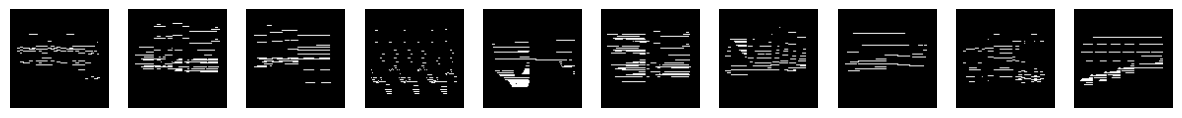

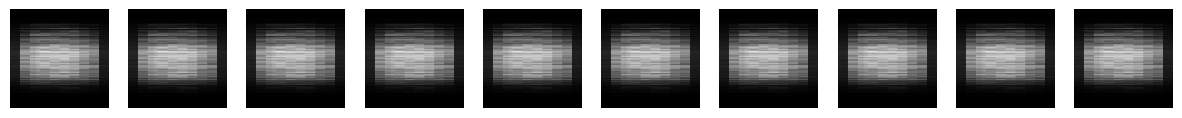

In [29]:
# reconstruct some images
def reconstruct_images(model, dataloader, num_images=10):
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            batch = (batch.view(batch.size(0), -1).float()/255).to(device)
            recon_batch, mu, logvar = model(batch)
            recon_batch = recon_batch.view(-1, 1, 100, 100).cpu().numpy()
            break
    return recon_batch[:num_images], batch[:num_images].view(-1, 1, 100, 100).cpu().numpy()
# Visualize the reconstructed images
def visualize_reconstructed_images(recon_images):
    fig, axes = plt.subplots(1, len(recon_images), figsize=(15, 5))
    for i, img in enumerate(recon_images):
        axes[i].imshow(img[0], cmap='gray')
        axes[i].axis('off')
    plt.show()
recon_images, ori_images = reconstruct_images(model, midi_dataloader, num_images=10)
visualize_reconstructed_images(ori_images)
visualize_reconstructed_images(recon_images)
